In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
from darkflow.net.build import TFNet

options = {"model": "./cfg/yolo.cfg", 
           "load": "./weights/yolo.weights", 
           "threshold": 0.1, 
           "gpu": 0.0}


### Build the model

In [3]:
tfnet = TFNet(options)

Parsing ./cfg/yolo.cfg
Loading ./weights/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.050896644592285156s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
Instructions for updating:
Colocations handled automatically by placer.
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2

In [4]:
import pprint as pp

# original_img = cv2.imread("sample_multiple_objects.jpg")
original_img = cv2.imread("orig_image.png")
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
results = tfnet.return_predict(original_img)

# pp.pprint(results)

### Display the image before boxing

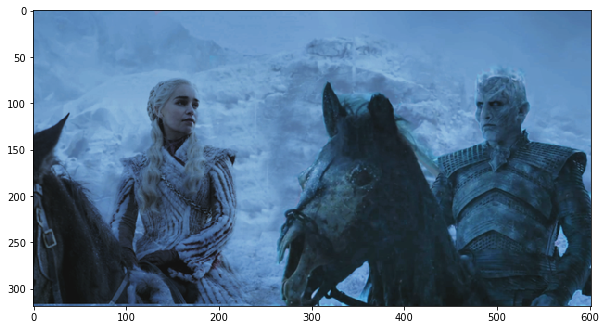

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(original_img)

### Boxing function

I define boxing() function to draw boxes, labels, and confidence value around the detected objects on the image. I initially set the threshold to 0.1 so that I can let TFNet detects as many object as possible and decide to restrict the number of resulting object later. I set the filter value for the threshold (confidence) to 0.3 here.

In [6]:
def boxing(original_img, predictions):
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))

        if confidence > 0.3:
            newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 1)
            newImage = cv2.putText(newImage, label, (top_x, top_y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
            
    return newImage

### Boxing results

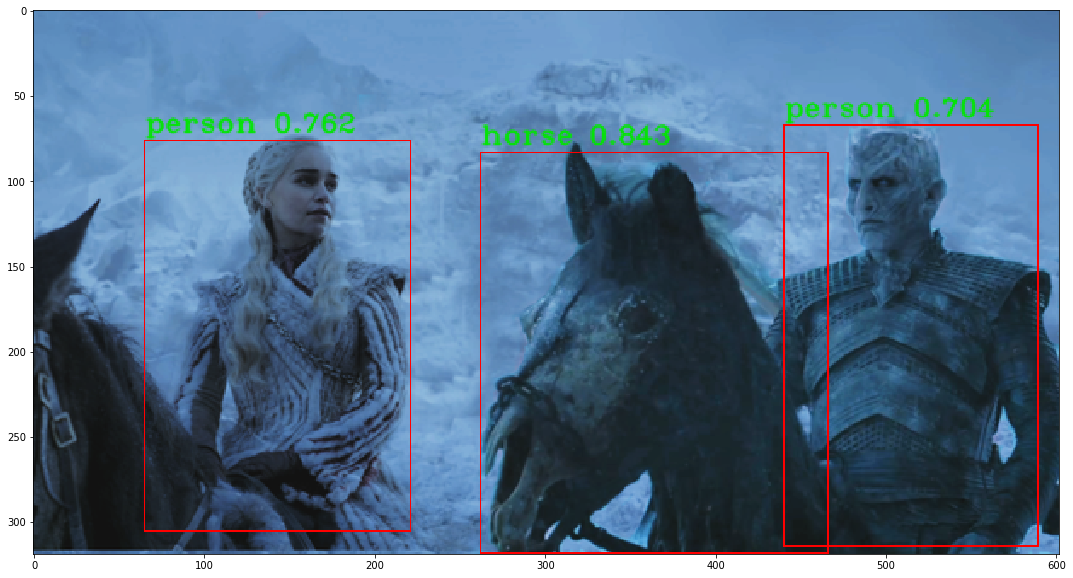

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(boxing(original_img, results))

### Boxing on video

In [9]:
# Take video from a file
# cap = cv2.VideoCapture('videoplayback.mp4')

# Take video feed directly from the camera
cap = cv2.VideoCapture(0)

width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) 

# Writing video to a file with the detection boxes
# fourcc = cv2.VideoWriter_fourcc(*'DIVX')
# out = cv2.VideoWriter('output.mp4',fourcc, 20.0, (int(width), int(height)))

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if ret == True:
        frame = np.asarray(frame)
        results = tfnet.return_predict(frame)

        new_frame = boxing(frame, results)

        # Display the resulting frame
        # out.write(new_frame)  # write the video with detections to a file
        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# When everything done, release the capture
cap.release()
# out.release()
cv2.destroyAllWindows()